In [1]:
import gsw
import numpy as np
import xarray as xr
import os
import sys
import pandas as pd
import time
import matplotlib.pyplot as plt
sys.path.insert(1, '/glade/u/home/lettier/analysis/')
import master_utils as myf

## Decompose overturning into thermal wind component and Ekman component
- Follow methodology in Levang & Schmitt (2020)

#### Define constants

In [2]:
g = 9.81 # m s^-2
rho_0 = 1030 # kg/m^3 density for seawater (not freshwater)
f = 2.*(7.2921e-5)*np.sin(40) # rad/s, order 10^-4
d_ek = 100. # m, Approx Ekman layer depth

#### Define basin geometry
To get the basin width as a function of depth $L(z)$, look at some ocean model output regridded onto a regular grid.
Pull out 40N, roughly grab North Atlantic, find east and west locations where there is a temperature at 2000m depth

In [3]:
ds = xr.open_dataset('/glade/scratch/lettier/anom_nudge_era.pop.h.1979-01.TEMP.remap1deg.nc').squeeze()
ds['z_t'] = ds.z_t/100.
mydata = ds.interp(z_t=2000).TEMP.interp(latitude=40)
mydata = mydata.where(mydata.longitude>-100).where(mydata.longitude<-7)
mydata = mydata.where(mydata==mydata,drop=True)
lon1 = mydata.longitude.min()
lon2 = mydata.longitude.max()

This is the cross section to use

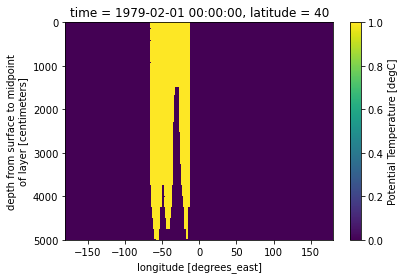

In [4]:
ds = ds.interp(latitude=40)
natl = ds.TEMP.where(ds.longitude>lon1).where(ds.longitude<lon2)
natl.values = np.where(natl==natl,1.,0.)
fig, ax = plt.subplots(1)
natl.plot(ax=ax)
ax.set_ylim([5000,0])
plt.show()

Compute $L(z)$ - need number of metres in a degree of longitude at 40N 

In [5]:
no_lons = natl.sum(dim='longitude')
r_e = 6.3781e6 # m 
d = 2.*r_e*np.arcsin(np.sqrt(((np.cos(40*np.pi/180))**2.)*(np.sin(np.pi/2./180.))**2.)) # meters
Lz = (no_lons*d).to_dataset(name='x')
Lz.x.attrs = {}
Lz.x.attrs['units']='m'
dz = Lz.z_t.diff(dim='z_t') 
dz.attrs['units']='m'

In [6]:
print('So at the surface, the distance is {:.2f}  km'.format(Lz.x.sel(z_t=5).values/1e3))

So at the surface, the distance is 4519.56  km


#### Now we need the density at the west and east sides of the basin, ie at 40N, lon1 and lon2. Let's find the gridcells closest to this

In [7]:
ds = xr.open_dataset('/glade/scratch/wriggles/archive/anom_nudge_era/ocn/hist//anom_nudge_era.pop.h.1979-01.nc')[['TEMP','TLONG','TLAT']].isel(z_t=0).squeeze()

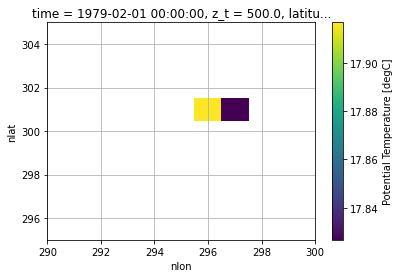

In [8]:
fig, ax = plt.subplots(1)
ds.where(ds.TLAT>39.8).where(ds.TLAT<=40.25).where(ds.TLONG>360+lon1-1).where(ds.TLONG<=360+lon1+1).TEMP.plot(ax=ax)
ax.set_ylim([295,305])
ax.set_xlim([290,300])
ax.grid()

nlat_w = 301
nlon_w = 297
lat_w = ds.TLAT.sel(nlat=nlat_w).sel(nlon=nlon_w)
lon_w = ds.TLONG.sel(nlat=nlat_w).sel(nlon=nlon_w)

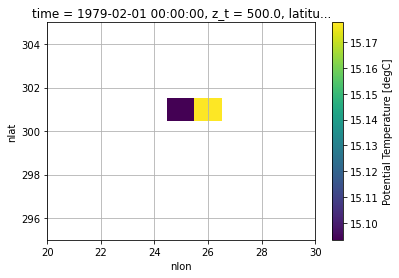

In [9]:
fig, ax = plt.subplots(1)
ds.where(ds.TLAT>39.8).where(ds.TLAT<=40.25).where(ds.TLONG>360+lon2-1).where(ds.TLONG<=360+lon2+1).TEMP.plot(ax=ax)
ax.set_ylim([295,305])
ax.set_xlim([20,30])
ax.grid()

nlat_e = 301
nlon_e = 26
lat_e = ds.TLAT.sel(nlat=nlat_e).sel(nlon=nlon_e)
lon_e = ds.TLONG.sel(nlat=nlat_e).sel(nlon=nlon_e)

#### Open model output profiles at these coordinates

In [10]:
ds = xr.open_dataset('/glade/scratch/wriggles/archive/anom_nudge_era/ocn/hist/anom_nudge_era.pop.h.1979-01.nc')[['TEMP','SALT','VVEL']]
ds['z_t'] = ds.z_t/100.
ds.z_t.attrs['units'] = 'm'

In [11]:
def get_sigma(ds): # function to compute sigma0

    pressure = xr.apply_ufunc(gsw.p_from_z, -ds.z_t, ds.TLAT, dask='parallelized', 
                               output_dtypes=[float, ]).rename('pressure')
    pressure.attrs['units'] = 'dbar'

    # absolute salinity from practical salinity
    abs_salinity = xr.apply_ufunc(gsw.SA_from_SP, ds.SALT, pressure,
                                  ds.TLONG, ds.TLAT, dask='parallelized',
                                  output_dtypes=[float,]).rename('abs_salinity')
    abs_salinity.attrs['units'] = 'g/kg'

    cthetao = xr.apply_ufunc(gsw.CT_from_pt, abs_salinity, ds.TEMP, dask='parallelized',
                                    output_dtypes=[float,]).rename('cthetao')

    cthetao.attrs['units'] = 'degC'

    # calculate sigma0 - potential density anomaly with reference pressure of 0 dbar, 
    # this being this particular potential density minus 1000 kg/m^3.
    sigma0 = xr.apply_ufunc(gsw.density.sigma0, abs_salinity, cthetao, dask='parallelized', 
        output_dtypes=[float, ]).rename('sigma0')
    sigma0.attrs['units']='kg/m^3'
    
    return sigma0

In [12]:
sigma0 = get_sigma(ds).squeeze()

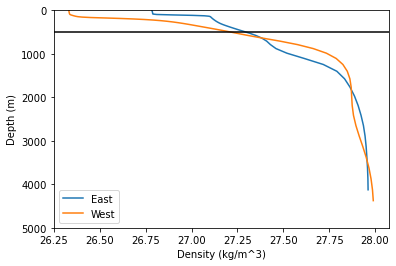

In [13]:
fig, ax = plt.subplots(1)
ax.plot(sigma0.sel(nlat=nlat_e).sel(nlon=nlon_e), ds.z_t,label='East')
ax.plot(sigma0.sel(nlat=nlat_w).sel(nlon=nlon_w), ds.z_t,label='West')
ax.axhline(y=500,c='k')
ax.set_ylim([5000,0.])
ax.legend()
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Density (kg/m^3)')
plt.show()

## Thermal wind component

Compute vg at these coordinates, via $\overline{v}_g(z) = \frac{g}{\rho_0f} \int_{-H}^{z} \frac{1}{L(z)} (\rho_w - \rho_e)dz$

In [55]:
def compute_vg (sigma0):
    
    vg_integrand = ((g/f/rho_0)*((sigma0.sel(nlat=nlat_w).sel(nlon=nlon_w)-sigma0.sel(nlat=nlat_e).sel(nlon=nlon_e)))*dz/Lz.x).compute()
    vg_integrand = vg_integrand.where(vg_integrand.z_t<3000) # approx depth of no motion
    vg = (vg_integrand.sel(z_t = vg_integrand.z_t.values[::-1])).cumsum(dim='z_t').compute() # reverse so get H, H-1, H-2
    
    return vg

In [56]:
vg = compute_vg(sigma0)

In [57]:
# Read in vo from model output to compare magnitude
# As geostrophic component should dominante this
approx_vvel = ds.where(ds.TLAT>39.8).where(ds.TLAT<=40.25).where(ds.TLONG>360+lon2-1).where(ds.TLONG<=360+lon2+1).VVEL.mean(dim=('nlat','nlon')).squeeze()

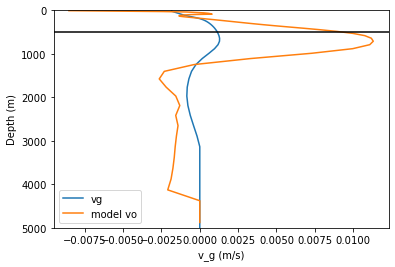

In [58]:
fig, ax = plt.subplots(1) #compare to zonal avg vo for magnitude
ax.plot(vg, vg.z_t,label='vg')
ax.plot(approx_vvel.squeeze()/100., (approx_vvel.z_t),label='model vo')

ax.axhline(y=500,c='k')
ax.set_ylim([5000,0.])
ax.set_ylabel('Depth (m)')
ax.set_xlabel('v_g (m/s)')
plt.legend()
plt.show()

In [62]:
(vg*dz).z_t

<xarray.DataArray 'z_t' (z_t: 59)>
array([5375.      , 5125.02832 , 4875.083496, 4625.19043 , 4375.392578,
       4125.768066, 3876.451904, 3627.67041 , 3379.793457, 3133.404785,
       2889.384766, 2649.001221, 2413.97168 , 2186.456543, 1968.944214,
       1764.003296, 1573.946411, 1400.497192, 1244.566895, 1106.204224,
        984.705872,  878.825256,  787.002502,  707.563293,  638.86261 ,
        579.372864,  527.728027,  482.736725,  443.377686,  408.784637,
        378.227631,  351.093475,  326.867981,  305.119232,  285.483643,
        267.654205,  251.370163,  236.408829,  222.578278,  209.71138 ,
        197.660278,  186.291275,  175.47905 ,  165.098404,  155.      ,
        145.      ,  135.      ,  125.      ,  115.      ,  105.      ,
         95.      ,   85.      ,   75.      ,   65.      ,   55.      ,
         45.      ,   35.      ,   25.      ,   15.      ])
Coordinates:
  * z_t       (z_t) float64 5.375e+03 5.125e+03 4.875e+03 ... 35.0 25.0 15.0
    time      object 1979-02-01 00:00:00
    latitude  int64 40
Attributes:
    long_name:  depth from surface to midpoint of layer
    units:      m
    positive:   down
    valid_min:  500.0
    valid_max:  537500.0

In [59]:
extra_term = (vg*dz).cumsum(dim='z_t')/vg.z_t.max()

In [64]:
strm_geo_integrand = (Lz.x*(vg-extra_term)*dz) 
strm_geo = strm_geo_integrand.sel(z_t = strm_geo_integrand.z_t.values[::-1]).cumsum(dim='z_t')

No handles with labels found to put in legend.


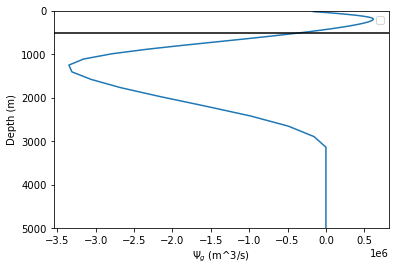

In [65]:
fig, ax = plt.subplots(1)
ax.plot(strm_geo, vg.z_t)
ax.set_ylim([5000,0.])
ax.axhline(y=500,c='k')
ax.legend()
ax.set_ylabel('Depth (m)')
ax.set_xlabel('$\Psi_g$ (m^3/s)')
plt.show()
# maybe this needs a minus?

In [66]:
abs(strm_geo).max().values/1e6

3.3493305303715095

## Ekman component

Get windstress across the section

In [40]:
atmds = xr.open_dataset('/glade/scratch/wriggles/archive/anom_nudge_era/atm/hist/anom_nudge_era.cam.h0.1979-01.nc')[['TAUX']]

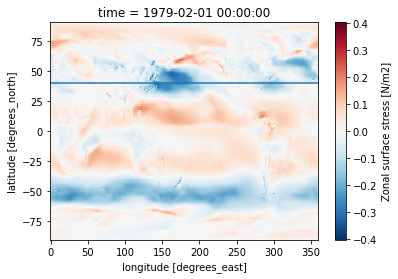

In [41]:
fig, ax = plt.subplots(1)
atmds.TAUX.plot(ax=ax)
ax.axhline(y=40)
plt.show()

At 40N, TAUX is negative - i.e. easterly (from the east)

In [42]:
taux = atmds.TAUX.interp(lat=40)
taux = taux.where(taux.lon>288.5).where(taux.lon<=349.5).mean(dim='lon').squeeze()
print(taux.values)

-0.07894677318824782


$v_{ek} = - \frac{\tau^x}{\rho_0 f D_{ek}}$

In [43]:
v_ek = -taux/(rho_0*f*d_ek)

In [44]:
strm_ek_integrand = v_ek*Lz.x*dz

In [67]:
strm_ek = strm_ek_integrand.cumsum(dim='z_t') # this integral is from z to surface

No handles with labels found to put in legend.


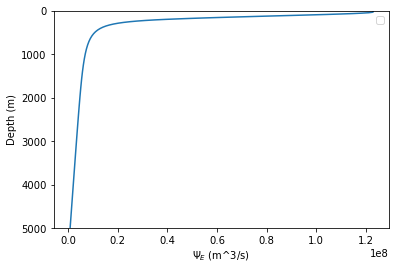

In [68]:
fig, ax = plt.subplots(1)
ax.plot(strm_ek, vg.z_t)
ax.set_ylim([5000,0.])
ax.legend()
ax.set_ylabel('Depth (m)')
ax.set_xlabel('$\Psi_E$ (m^3/s)')
plt.show()